TOPICOS QUE PODEM SER INTERESSANTES:
- Ver como se comportam as networks com palavras com mais que um significado.
- Existem networks, por exemplo, de cenas relacionadas com racismo? Se sim, pode ser usado para detenção. (MOTIFS)
- Falar de que temos um set de bues palavras mas um texto nao usa tantas palavras, procurar quantas palavras diferentes costuma ter um texto e criar uma random network com isso.

In [1]:
import sys

# # Install requirements.txt
# !"{sys.executable}" -m pip install -r requirements.txt

# !python -m textblob.download_corpora

In [2]:
from scipy.optimize import curve_fit
from src.random_text import get_text as get_random_text
from src.text_to_network import get_network
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from textblob import TextBlob
import networkx as nx
import pandas as pd
import contractions
import numpy as np
import random

## Network Properties:

In order to compare all the networks, we're going to utilize the following metrics/properties:

1. Degree Distribuition + Average Degree: 

    É importante definir 3 situações: Um node só tem degree 1 se for um node no inicio ou no final de TODO o texto + não se repetindo. Um node tem degree 2 se for uma palavra que só se repete uma única vez no texto. Sempre que uma palavra se repete, terá sempre degree ímpar, considerando que se a palavra após for uma palavra que também estava após da mesma palavra numa recorrência anterior é considerada um novo edge.

    Probabilidade de haver um node com degree n > 2, num set de K palavras: $$P(k,n)=\frac{1}{\prod_{i=0}^{n-2}k-i}\times(\frac{1}{k})^{n}$$

2. Average Path Length + Diameter:

3. Clustering Coefficient:

4. Connected Components:
We're expecting to have one connected component for any big enough network, so we are not going to consider this metric to be a valid one for comparing networks

5. Subgraph distribution:
This may be a fingerprit of the author/publisher of the text. Further explore

6. Z-Score for most relevant motif

7. Degree Centrality

8. Betweeness Centrality

9. Shortest Path Distribution


In [3]:
from src.network_properties import EvaluateNetworks

evaluations = [
    'degree_distribution',
    'avg_path_length',
    'diameter',
    'clustering_coefficient',
    #'z_score',
    'degree_centrality',
    'betweeness_centrality',
    'shortest_path_distribution',
]

## Real Network Analysis

We're going to analyze a real text (Fellowship of the ring) to first get a understanding of some underlying features that make a word adjacency network real.

After that, we'll try to build a model which generates a network similar to the real one.

### Reading the dataset

In [4]:
# Fellowship Of The Ring for random network definition purposes:
with open('The Fellowship Of The Ring.txt', 'r') as file:
    # Read the content of the file
    # Fix the contractions (ex: They're -> They are / Bilbo's -> Bilbos)
    # Make it a textblob
    real_text = TextBlob(contractions.fix(file.read()))

# setting every word to lowercase
real_text.words = real_text.words.lower()

# removing (".", "_") and ' when it starts a word
for i in range(len(real_text.words)):
    word = real_text.words[i]
    word = word.replace(".", "").replace("_", "").lstrip("'")
    real_text.words[i] = word

# number of words
n_words = len(real_text.words)
print('Fellowship Of The Ring has: ' + str(n_words) + ' words.')

# number of distinct words
n_distinct_words = len(set(real_text.words))
print('Fellowship Of The Ring has: ' + str(n_distinct_words) + ' distinct words.')


# Uniting all the words that were extracted creating what we called a "giga_phrase", a phrase that represents the entire book without paragraphs, periods or chapters
giga_phrase = ' '.join(real_text.words)
real_network = get_network(giga_phrase, weighted=False)

Fellowship Of The Ring has: 179543 words.
Fellowship Of The Ring has: 8822 distinct words.


In [ ]:
real = EvaluateNetworks(real_network, evaluations=evaluations)

real.evaluate()

### Network Properties

#### Degree Distribution + Average Degree

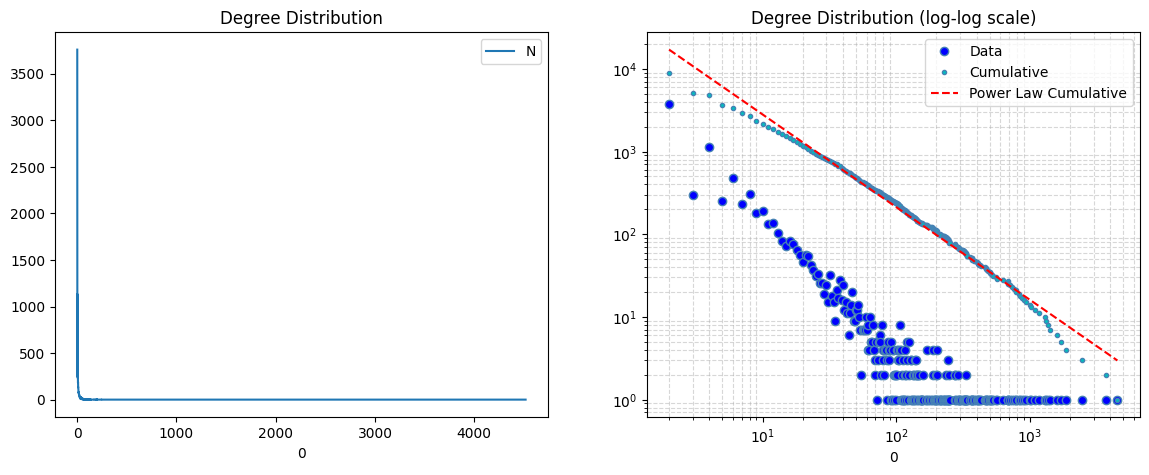

Estimated Power-Law: -2.1208759976169205


In [ ]:
# avg_degree
avg_degree = np.mean([d for _, d in real_network.degree()])


# Degree Distribution
degree_frequencies = pd.DataFrame.from_dict(dict(real_network.degree), orient='index')
degree_frequencies['N'] = 0
degree_frequencies = degree_frequencies.groupby(by=[0]).count().sort_values(by=[0], ascending=True).reset_index()

(fig, axs) = plt.subplots(ncols=2, nrows=1, figsize=(14, 5))

axs[1].grid(True, which="both", linestyle='--', alpha=0.5)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].tick_params(axis='both', which='minor', labelsize=8)


# Normal scale
degree_frequencies.plot(title='Degree Distribution', x=0, y='N', ax=axs[0], xlabel=None)


# Calculate power law estimated
degree_frequencies['N_Cumulative'] = degree_frequencies['N'][::-1].cumsum()

# Define the power law function
def power_law(x, a, b):
    return a * x + b
# Fit the power law using curve_fit
params, _ = curve_fit(power_law, np.log(degree_frequencies[0]), np.log(degree_frequencies['N_Cumulative']))
degree_frequencies['Expected'] = degree_frequencies.apply(lambda row: np.exp(power_law(np.log(row[0]), *params)), axis=1)

degree_frequencies.plot(
    title='Degree Distribution (log-log scale)'
    ,ax=axs[1]
    ,loglog=True
    ,markersize=6
    ,markeredgecolor='steelblue'
    ,x=0
    ,y=['N', 'N_Cumulative', 'Expected']
    ,label=['Data', 'Cumulative', 'Power Law Cumulative']
    ,style=['bo', 'c.', 'r--']
)

plt.show()

# Print the estimated power-law exponent
print('Estimated Power-Law:', params[0]-1)

Which is already very different from the random text, while it was ~35 we can see that it lowered to ~17.4

#### Average Path Length + Diameter

In [ ]:
avg_path_length = nx.average_shortest_path_length(real_network) # The average path length
diameter = nx.diameter(real_network)                            # Diameter

Shortest Path Frequency Distribution

Average path length is: 3.161644178245629
Diameter is: 27


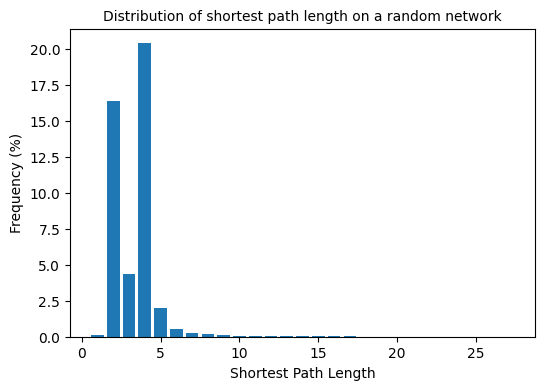

In [ ]:
# We know the diameter, so create an array
# to store values from 0 up to (and including) diameter
path_lengths = np.zeros(diameter + 1, dtype=int)
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(real_network))
# Extract the frequency of shortest path lengths between two nodes
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts
# Express frequency distribution as a percentage (ignoring path lengths of 0)
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()
# Plot the frequency distribution (ignoring path lengths of 0) as a percentage
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title("Distribution of shortest path length on a random network", fontdict={"size": 10}, loc="center")
ax.set_xlabel("Shortest Path Length", fontdict={"size": 10})
ax.set_ylabel("Frequency (%)", fontdict={"size": 10})
print('Average path length is: ' + str(avg_path_length))
print('Diameter is: ' + str(diameter))

We can see that the Diameter is way bigger, however, it looks like we can consider it as an outlier because the average path is lower! Looks like the network is even more connected!

#### Degree Centrality

These are the top 10 nodes with highest degree centrality:
and -> 0.5120734610588369
the -> 0.42058723500736883
of -> 0.28035370139439975
a -> 0.2098401541775309
to -> 0.19374220609908174
in -> 0.18183879378755244
he -> 0.16052601745833806
that -> 0.15361070173449723
it -> 0.14998299512526925
was -> 0.1462419226845029
These are the 10 nodes with lowest degree centrality:
overtook -> 0.00022673166307674868
badly -> 0.00022673166307674868
screwed -> 0.00022673166307674868
brushing -> 0.00022673166307674868
stock-still -> 0.00022673166307674868
flounder -> 0.00022673166307674868
water-rat -> 0.00022673166307674868
nuisances -> 0.00022673166307674868
emptied -> 0.00022673166307674868
shouldering -> 0.00022673166307674868
The average degree centrality is: 0.00197399442824029


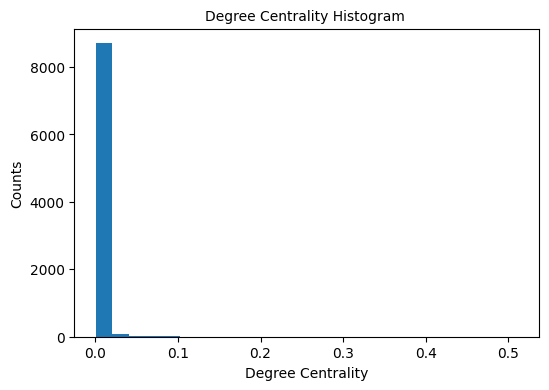

In [ ]:
# degree centrality
degree_centrality = nx.centrality.degree_centrality(real_network)
# Compute the average degree centrality for each node
average_degree_centrality = np.mean(list(degree_centrality.values()))
# top 10 nodes by degree centrality
centrality = (sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))
top_10_centrality = centrality[:10]
last_10_centrality = centrality[-10:]
print("These are the top 10 nodes with highest degree centrality:\n" + '\n'.join([f"{node} -> {centrality_value}" for node, centrality_value in top_10_centrality]))
print("These are the 10 nodes with lowest degree centrality:\n" + '\n'.join([f"{node} -> {centrality_value}" for node, centrality_value in last_10_centrality]))

# highest degre centrality node
# highest_centrality = centrality[0][1]
# plot histogram
plt.figure(figsize=(6, 4))
plt.hist(degree_centrality.values(), bins=25)
# plt.xticks(ticks=[0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007])  # set the x axis ticks
plt.title("Degree Centrality Histogram ", fontdict={"size": 10}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 10})
plt.ylabel("Counts", fontdict={"size": 10})
print('The average degree centrality is: ' + str(average_degree_centrality))

#### Betweeness Centrality

These are the top 10 nodes with highest betweenness centrality:
and -> 0.2373053639528676
the -> 0.19323769613535074
of -> 0.11039639086170566
a -> 0.0795212714309509
to -> 0.05223933744265723
in -> 0.0460297821877604
he -> 0.041351539400188174
it -> 0.03648727430864906
that -> 0.03468297125039529
was -> 0.034662867868526424
These are the 10 nodes with lowest betweenness centrality:
schooling -> 0.0
speak-we -> 0.0
have-since -> 0.0
screws -> 0.0
aloof -> 0.0
arrange-here -> 0.0
badly -> 0.0
screwed -> 0.0
emptied -> 0.0
shouldering -> 0.0


Text(0, 0.5, 'Counts')

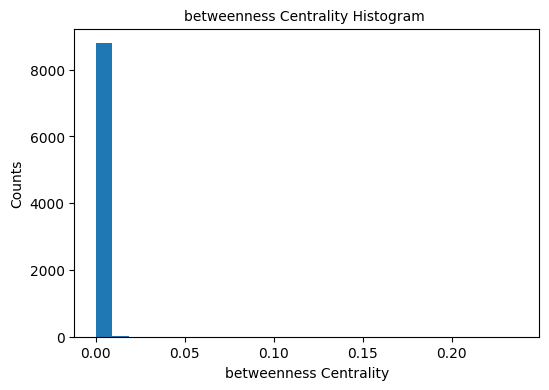

In [ ]:
# betweenness centrality
betweenness_centrality = nx.centrality.betweenness_centrality(real_network)
# top 10 nodes by betweenness centrality
betweeness = (sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))
top_10_betweeness = betweeness[:10]
last_10_betweeness = betweeness[-10:]
print("These are the top 10 nodes with highest betweenness centrality:\n" + '\n'.join([f"{node} -> {centrality_value}" for node, centrality_value in top_10_betweeness]))
print("These are the 10 nodes with lowest betweenness centrality:\n" + '\n'.join([f"{node} -> {centrality_value}" for node, centrality_value in last_10_betweeness]))
# highest degre centrality node
# highest_centrality = centrality[0][1]
# plot histogram
plt.figure(figsize=(6, 4))
plt.hist(betweenness_centrality.values(), bins=25)
# plt.xticks(ticks=[0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001])  # set the x axis ticks
plt.title("betweenness Centrality Histogram ", fontdict={"size": 10}, loc="center")
plt.xlabel("betweenness Centrality", fontdict={"size": 10})
plt.ylabel("Counts", fontdict={"size": 10})

## Network models

In this section, we'll try to experiment with different models to visualize if we can find a model which represents the word adjacency network (either generate the network directly, or by generating a text)

### Text Generating models

First we'll approach the model searching by generating random sentences using the English dictionary. In here we are trying to find some logic behind the text construction which may lead to a network similar to the real network. By finding a list of rules which generate a network similar to the real one, we may be able to generate a new language, or not, who knows?


#### Uniform Distribution

In this section, we'll analyze how a text where each word has been randomly selected behaves so that we can compare it with a actual network

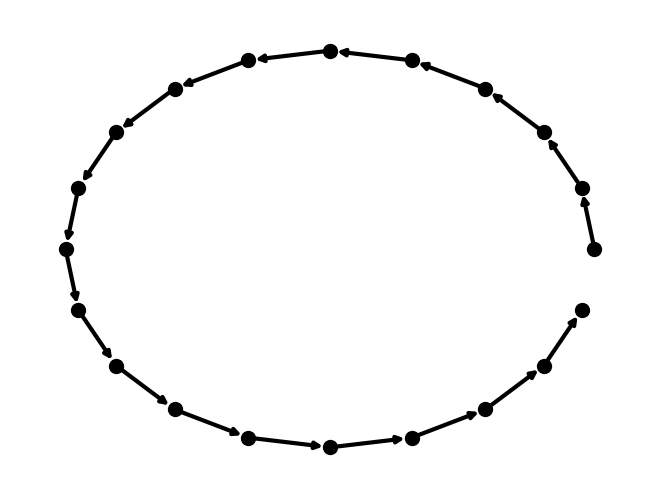

In [ ]:
text = get_random_text(size=20)

network = get_network(text, weighted=False)

options = {
    'node_color': 'black',
    'node_size': 100,
    'width': 3,
}
nx.draw_circular(network, **options)
nw = plt.show()

##### Brief Summary

After analyzing the above-generated network, we can conclude usual texts definitely behave differently than total randomness (as expected of humans).
We'll further try to improve this random word generator to further understand real-world word frequency networks

#### Power Law distribution

Very similar to the above section, but using a Power-law distribution for the word frequency instead of a uniform one.

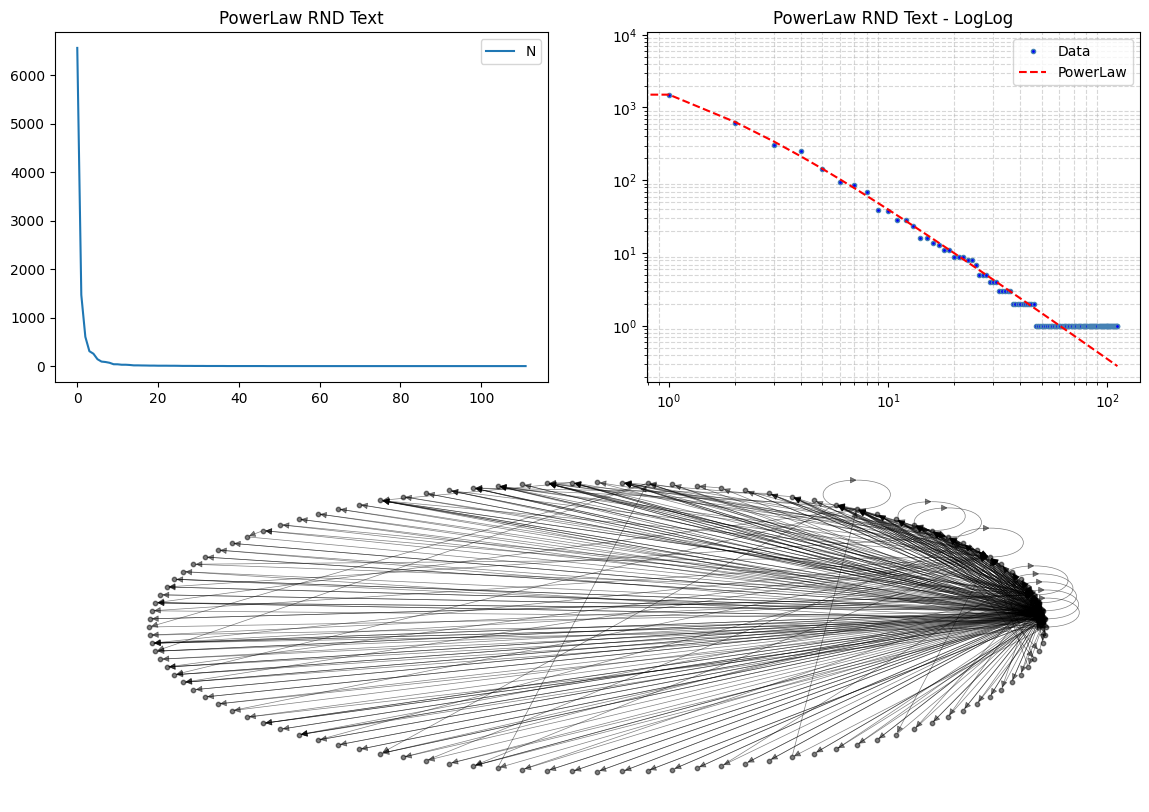

In [ ]:
POWER_LAW_EXPONENT = 2.13

text = get_random_text(size=10000, power_law_exponent=POWER_LAW_EXPONENT)

# Verifying the text generated has word frequency obeying a power-law
frequencies = pd.DataFrame(text.split(" "))
frequencies['N'] = 0
frequencies = frequencies.groupby(by=[0]).count().sort_values(by=['N'], ascending=False).reset_index()
frequencies['PowerLaw'] = frequencies.apply(lambda row: frequencies['N'].iloc[0]*(row.name+1)**(-POWER_LAW_EXPONENT), axis=1)


gs = gridspec.GridSpec(2, 2, figure=plt.figure(figsize=(14, 10)))
ax = plt.subplot(gs[0, 1])
ax.grid(True, which="both", linestyle='--', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)


# Normal scale
frequencies.plot(title='PowerLaw RND Text', y='N', ax=plt.subplot(gs[0, 0]), xlabel=None)
# Log-log scale
frequencies.plot(
    title='PowerLaw RND Text - LogLog'
    ,ax=ax
    ,loglog=True
    ,markersize=3
    ,markeredgecolor='steelblue'
    ,xlabel=None
    ,y=['N', 'PowerLaw']
    ,label=['Data', 'PowerLaw']
    ,style=['bo', 'r--']
)

# Plot network
network = get_network(text, weighted=False)
options = {
    'node_color': 'black',
    'node_size': 10,
    'width': 0.5,
    'alpha': 0.5,
}
nx.draw_circular(network, ax=plt.subplot(gs[1, :]), **options)

plt.show()

To try and understand a bit more if the network generated looks how a random text with power-law frequency distribution should behave, we're gonna scramble the words a few times and generate new networks to visualize the network generated.

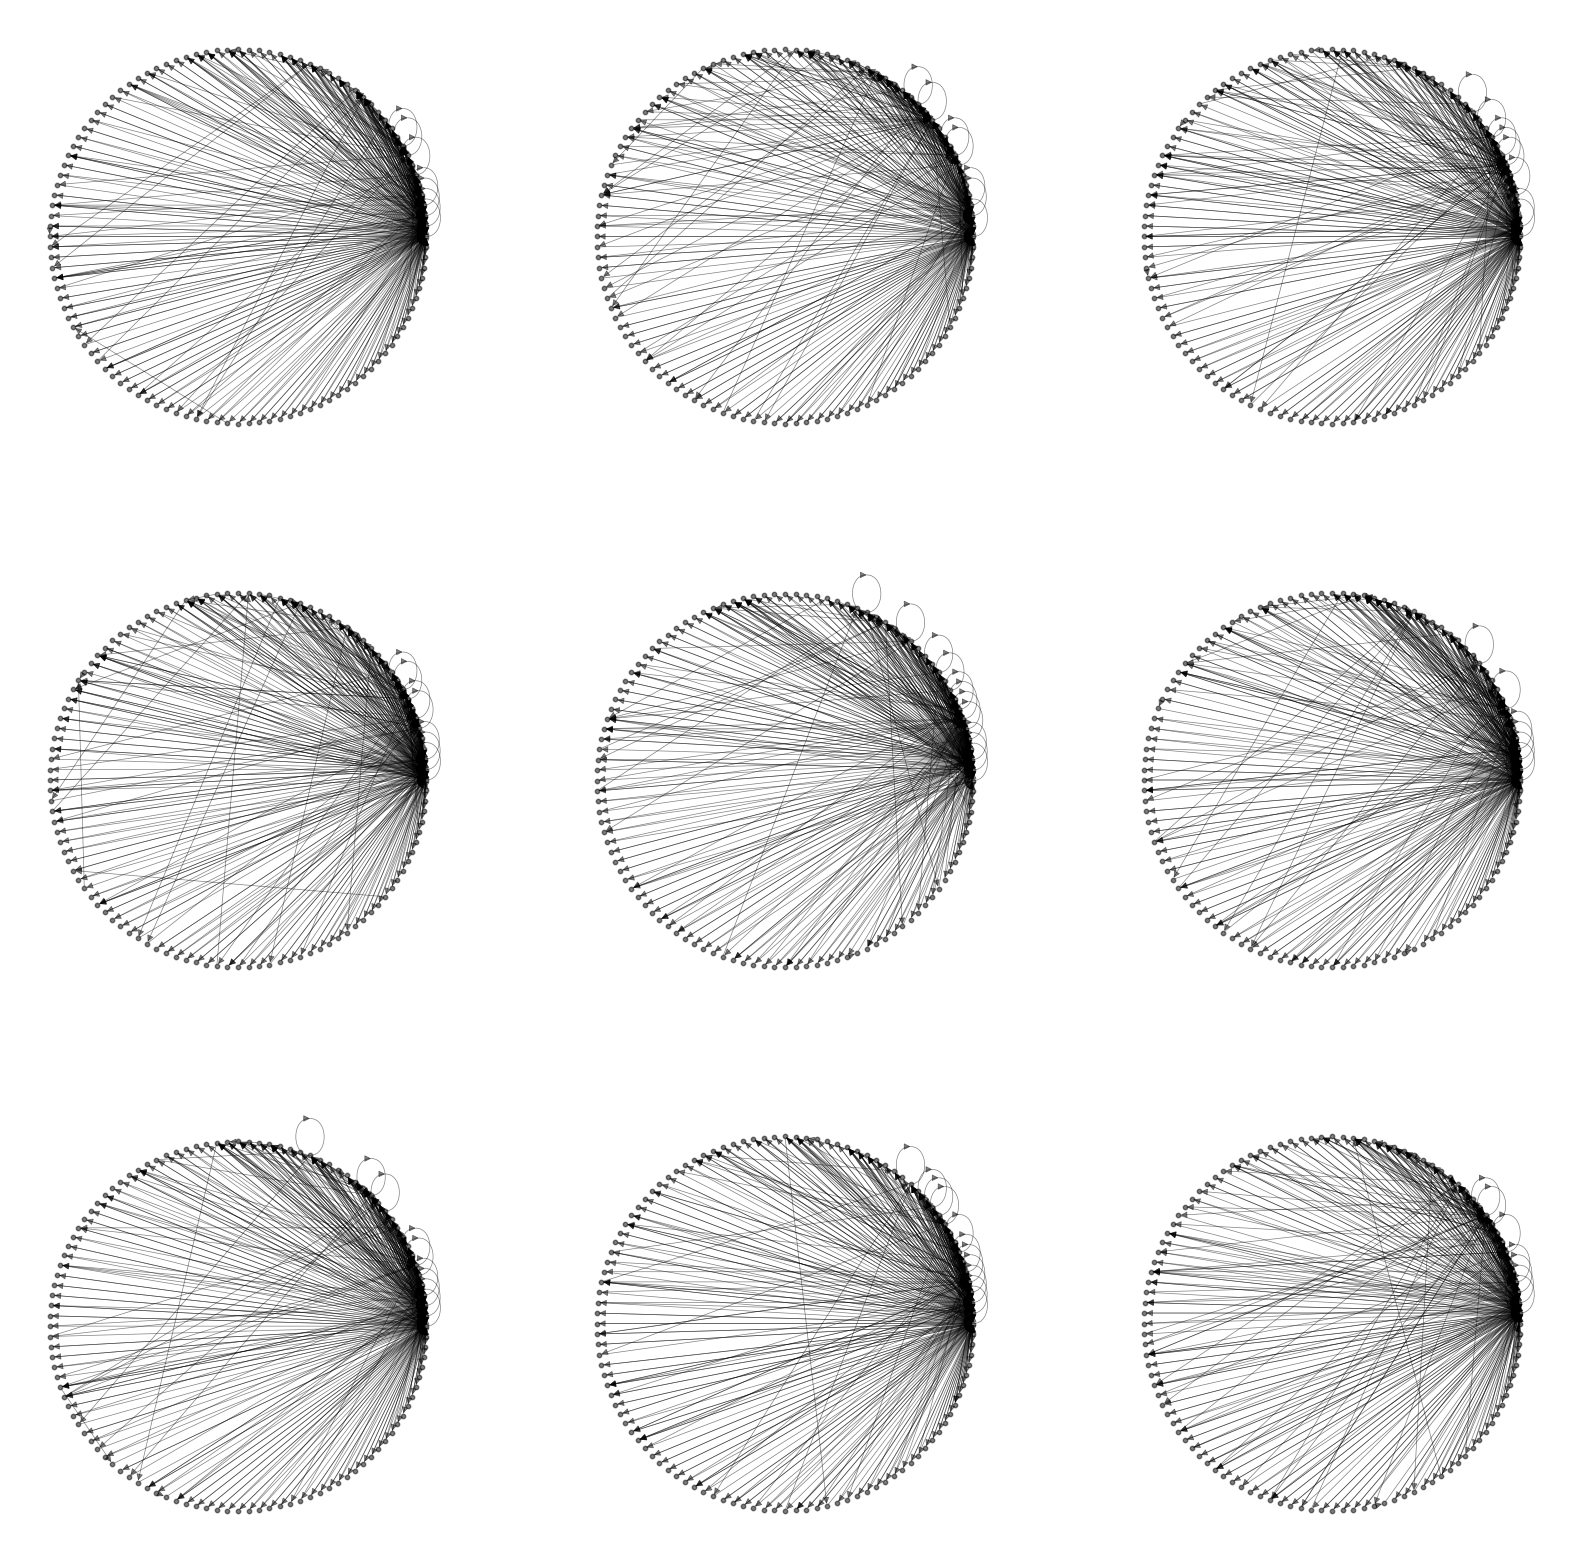

In [ ]:
N_TRIES = 9
ncols = 3
# Using number of cols and total number of tries, generate number of rows
nrows = N_TRIES//ncols + min(1, N_TRIES%ncols)


aux = text.split(" ")

# Iterate through number of tries
(_, axs) = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20,20))
for i in range(N_TRIES):
    random.shuffle(aux)

    network = get_network(' '.join(aux), weighted=False)
    nx.draw_circular(network, ax=axs[i//nrows][i%ncols], **options)

plt.show()

##### Brief Summary

After analyzing the above-generated networks, we can see that the well-known Power Law distribution is not enough to describe a real-world network for word adjacency.

This goes to show that human language is much more complex than what simple models may describe. We'll try to further improve our model to copy more properties of real-world texts to try and find a simple model which more accurately describes the real world word-adjacency networks. 

Another point to note:
* There exists self-loops with this model, we have to think of a way to remove this
* We need to add some way of creating ponctuation which separates words.
* Even though word frequency appears to follow a power-law distribution, there's more to it than that due to the fact that humans tend to try not to repeat words very frequently.

#### Using same words from real text

In this section we'll explore using the the real text but shuffling the words around to see what happens to the network

Average Path Length + Diameter

In [ ]:
### Generating a random network keeping the same words

# getting n_distinct_"words"
number_set = [str(num) for num in random.sample(range(1, n_distinct_words + 1), n_distinct_words)]
# getting a combination of n_words with n_distinct_words as the base set
random_text = ' '.join(random.choices(number_set, k=n_words))
# generating the network as a list of tuples
network = get_network(random_text, weighted=False)

# average degree
avg_degree = np.mean([d for _, d in network.degree()])

Shortest Path Frequency Distribution

Text(0, 0.5, 'Frequency (%)')

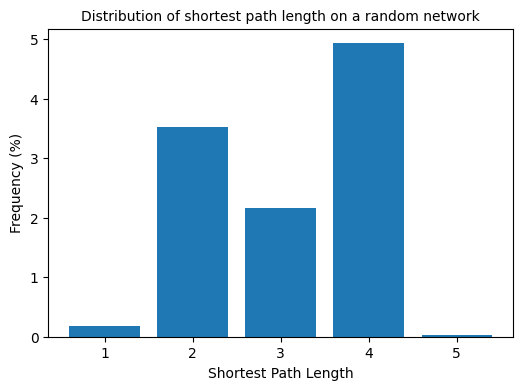

In [ ]:

# Code from: https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html (with a bit of tuning)

shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(network))
# Compute the average shortest path length for each node
average_path_lengths = [np.mean(list(spl.values())) for spl in shortest_path_lengths.values()]
# The average over all nodes
avg_path_lengths = np.mean(average_path_lengths)
# network diameter
diameter = max(nx.eccentricity(network, sp=shortest_path_lengths).values()) 
# We know the maximum shortest path length (the diameter), so create an array
# to store values from 0 up to (and including) diameter
path_lengths = np.zeros(diameter + 1, dtype=int)

# Extract the frequency of shortest path lengths between two nodes
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts

# Express frequency distribution as a percentage (ignoring path lengths of 0)
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

# Plot the frequency distribution (ignoring path lengths of 0) as a percentage
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title("Distribution of shortest path length on a random network", fontdict={"size": 10}, loc="center")
ax.set_xlabel("Shortest Path Length", fontdict={"size": 10})
ax.set_ylabel("Frequency (%)", fontdict={"size": 10})

Degree Centrality

These are the top 10 nodes with highest degree centrality:
7181 -> 0.008151620134501731
697 -> 0.007336458121051558
9800 -> 0.007336458121051558
8784 -> 0.007132667617689015
5728 -> 0.007132667617689015
998 -> 0.006725086610963929
4112 -> 0.006725086610963929
4824 -> 0.006725086610963929
6109 -> 0.006725086610963929
943 -> 0.006725086610963929


Text(0, 0.5, 'Counts')

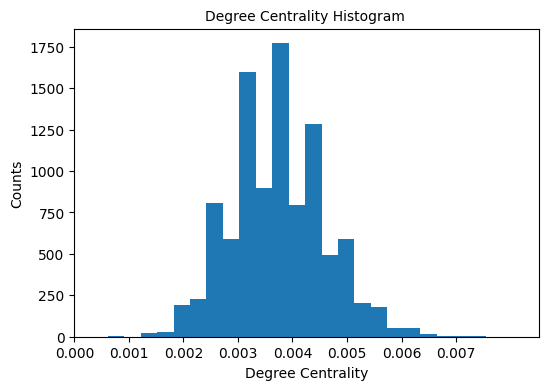

In [ ]:
# degree centrality
degree_centrality = nx.centrality.degree_centrality(network)
# Compute the average degree centrality for each node
average_degree_centrality = np.mean(list(degree_centrality.values()))
# top 10 nodes by degree centrality
centrality = (sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:10]
print("These are the top 10 nodes with highest degree centrality:\n" + '\n'.join([f"{node} -> {centrality_value}" for node, centrality_value in centrality]))
# highest degre centrality node
highest_centrality = centrality[0][1]
# plot histogram
plt.figure(figsize=(6, 4))
plt.hist(degree_centrality.values(), bins=25)
plt.xticks(ticks=[0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007])  # set the x axis ticks
plt.title("Degree Centrality Histogram ", fontdict={"size": 10}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 10})
plt.ylabel("Counts", fontdict={"size": 10})

Betweenness Centrality

These are the top 10 nodes with highest betweenness centrality:
7181 -> 0.0010879086742215931
697 -> 0.0008906341148167187
9800 -> 0.0008777726726703261
8784 -> 0.0008356303634490744
5728 -> 0.0008119810221245799
943 -> 0.0007710505447141232
4112 -> 0.0007666377433595286
4824 -> 0.0007612952444684077
998 -> 0.0007587834845213313
6109 -> 0.0007443240685028776


Text(0, 0.5, 'Counts')

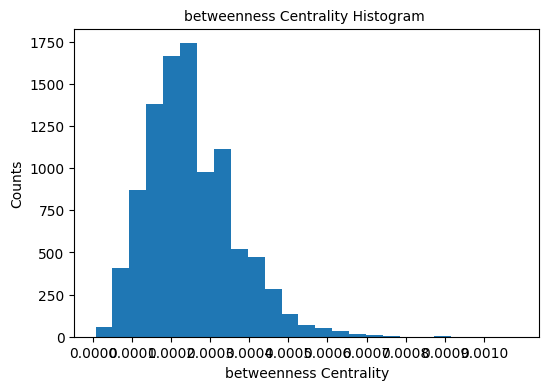

In [ ]:
# betweenness centrality
betweenness_centrality = nx.centrality.betweenness_centrality(network)
# top 10 nodes by betweenness centrality
centrality = (sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:10]
print("These are the top 10 nodes with highest betweenness centrality:\n" + '\n'.join([f"{node} -> {centrality_value}" for node, centrality_value in centrality]))
# highest degre centrality node
highest_centrality = centrality[0][1]
# plot histogram
plt.figure(figsize=(6, 4))
plt.hist(betweenness_centrality.values(), bins=25)
plt.xticks(ticks=[0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001])  # set the x axis ticks
plt.title("betweenness Centrality Histogram ", fontdict={"size": 10}, loc="center")
plt.xlabel("betweenness Centrality", fontdict={"size": 10})
plt.ylabel("Counts", fontdict={"size": 10})

Random Analysis

In [ ]:
def random_analysis(n):
    avg_list = []
    avg_path_lengths_list = []
    diameter_list = []
    avg_degree_centrality_list = []

    # Create a new figure for avg_list
    fig_avg, ax_avg = plt.subplots()

    # Create a new figure for avg_degree_centrality_list
    fig_degree, ax_degree = plt.subplots()

    # Create a new figure for avg_path_lengths_list
    fig_path_length, ax_path_length = plt.subplots()

    # Create a new figure for diameter_list
    fig_diameter, ax_diameter = plt.subplots()

    for i in range(n):
        # generate a random network for the current step
        number_set = [str(num) for num in random.sample(range(1, n_distinct_words + 1), n_distinct_words)]
        random_text = ' '.join(random.choices(number_set, k=n_words))
        network = get_network(random_text, weighted=False)
        # calculate the average degree
        avg_degree = np.mean([d for _, d in network.degree()])
        # calculate the average shortest path
        shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(network))
        average_path_lengths = [np.mean(list(spl.values())) for spl in shortest_path_lengths.values()]
        avg_path_lengths = np.mean(average_path_lengths)
        # calculate the diameter
        diameter = max(nx.eccentricity(network, sp=shortest_path_lengths).values()) 
        # calculate average degree centrality
        degree_centrality = nx.centrality.degree_centrality(network)
        average_degree_centrality = np.mean(list(degree_centrality.values()))
        # add the values to their lists
        avg_list.append(avg_degree)
        avg_path_lengths_list.append(avg_path_lengths)
        diameter_list.append(diameter)
        avg_degree_centrality_list.append(average_degree_centrality)

    # Set y-axis label
    ax_avg.set_ylabel('Value')
    ax_degree.set_ylabel('Value')
    ax_path_length.set_ylabel('Value')
    ax_diameter.set_ylabel('Value')

    # Set plot title
    ax_avg.set_title('avg_degree')
    ax_degree.set_title('avg_degree_centrality')
    ax_path_length.set_title('avg_path_length')
    ax_diameter.set_title('avg_diameter')

    # Plot avg_list in fig_avg
    ax_avg.boxplot(avg_list)

    # Plot avg_degree_centrality_list in fig_degree
    ax_degree.boxplot(avg_degree_centrality_list)

    # Plot avg_path_lengths_list in fig_path_length
    ax_path_length.boxplot(avg_path_lengths_list)

    # Plot diameter_list in fig_diameter
    ax_diameter.boxplot(diameter_list)

    # Display the plots
    plt.show()


random_analysis(100)